### Theory

#### Hypothesis Testing – The problem of multiple comparisons [5 points]

Experimentation in AI often happens like this: 

* Modify/Build an algorithm
* Compare the algorithm to a baseline by running a hypothesis test.
* If not significant, go back to step A
* If significant, start writing a paper. 

How many hypothesis tests, m, does it take to get to (with Type I error for each test = α):

1. P(mth experiment gives significant result | m experiments lacking power to reject H0)?
2. P(at least one significant result | m experiments lacking power to reject H0)?

#### Bias and unfairness in Interleaving experiments [10 points]
Balance interleaving has been shown to be biased in a number of corner cases. An example was given during the lecture with two ranked lists of length 3 being interleaved, and a randomly clicking population of users that resulted in algorithm A winning ⅔ of the time, even though in theory the percentage of wins should be 50% for both algorithms. Can you come up with a situation of two ranked lists of length 3 and a distribution of clicks over them for which Team-draft interleaving is unfair to the better algorithm?


In [1]:
import itertools
import numpy as np

# Added the numbers to facilitate easy sorting.
REL_SCORES = {'N' : 0, 'R' : 1, 'HR' : 2}

# Generate all possible rankings for both Production and Experimental systems
P = list(itertools.product(REL_SCORES.keys(), repeat = 5))
E = list(itertools.product(REL_SCORES.keys(), repeat = 5))
 
rankings = list(itertools.product(P, E))

# Make sure the right amount of combinations are made
assert len(rankings) == 3**10

# Show a sample of the generated rankings
for p, e in rankings[0::10000]:
    print(p)
    print(e)
    print()

('N', 'N', 'N', 'N', 'N')
('N', 'N', 'N', 'N', 'N')

('N', 'HR', 'HR', 'HR', 'R')
('N', 'HR', 'HR', 'N', 'HR')

('HR', 'N', 'N', 'N', 'HR')
('N', 'R', 'R', 'N', 'R')

('HR', 'HR', 'HR', 'R', 'N')
('HR', 'HR', 'N', 'HR', 'N')

('R', 'N', 'N', 'N', 'R')
('HR', 'R', 'HR', 'HR', 'HR')

('R', 'HR', 'HR', 'R', 'HR')
('R', 'N', 'R', 'HR', 'R')



In [4]:
# quote from slide 15: "usually user only looks at very few top results : e.g. precision@3"
def precision_at_k(ranking, k):
    subset = ranking[:k]
    n_relevant = 0
    
    for result in subset:
        if REL_SCORES[result] > 0:
            n_relevant += 1
    
    return n_relevant / k

def DGC_at_k(ranking, k, optimal=False):
    subset = ranking[:k]
    
    if optimal:
        subset = sorted(subset, reverse=True, key=lambda x: REL_SCORES[x])
        
    discounted_score = 0
    
    for i, result in enumerate(subset):
        # prepare variables for DGC formula
        rank = i + 1
        rel = REL_SCORES[result]
        
        # Calculate score
        score = (2**rel - 1) / np.log2(1 + rank)
        discounted_score += score
    
    # NB: sum is part of the formula
    return discounted_score
        
def nDGC_at_k(ranking, k):
    true = DGC_at_k(ranking, k)
    best = DGC_at_k(ranking, k, optimal=True)
    
    # This is to prevent dividing by 0. If the best possible DGC is 0, the
    # true DGC is also zero (because there are no relevant document is the top k)
    if best == 0.0: 
        return 0.0
    else:
        return true / best

def prob_of_relevance(grade, max_grade):
    return (2**grade - 1) / 2**max_grade

def ERR_naive(ranking):
    err = 0
    grades = [REL_SCORES[x] for x in ranking]
    max_grade = max(REL_SCORES.values())
    
    for i in range(len(grades)):
        prob_at_i = 1
        for j in range(i - 1):
            prob_at_i *= (1 - prob_of_relevance(grades[j], max_grade))
        
        prob_at_i *= prob_of_relevance(grades[i], max_grade)
        # (1/r) -> (1/i+1) because of zero indexing
        r = i + 1
        err += prob_at_i * (1 / r)
        
    return err

def ERR(ranking):
    """Algorithm to compute ERR in linear time, implemented based on 
    
    Chapelle, O., Metlzer, D., Zhang, Y., & Grinspan, P. (2009, November). 
    Expected reciprocal rank for graded relevance. In Proceedings of the 18th ACM conference
    on Information and knowledge management (pp. 621-630). ACM."""
    
    grades = [REL_SCORES[x] for x in ranking]
    max_grade = max(REL_SCORES.values())
    
    p = 1
    err = 0
    
    for r in range(len(grades)):
        R = prob_of_relevance(grades[r], max_grade)
        err += p * (R/(r+1))
        p *= (1 - R)
    
    return err

In [5]:
## This cell does te calculations for all three metrics and saves the results to a list    

depth = 5

precision_p = []
precision_e = []
dgc_p = []
dgc_e = []
err_p = []
err_e = []

for i, (p, e) in enumerate(list(rankings)):
    precision_p.append(precision_at_k(p, depth))
    precision_e.append(precision_at_k(e, depth))

    dgc_p.append(nDGC_at_k(p, depth))
    dgc_e.append(nDGC_at_k(e, depth))
    
    err_p.append(ERR(p))
    err_e.append(ERR(e))

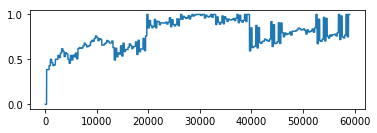

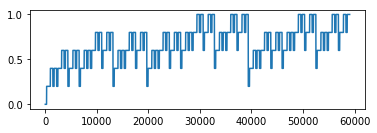

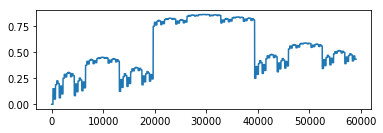

In [6]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(range(len(dgc_p)), dgc_p)

# plt.subplot(212)
# plt.plot(range(len(dgc_e)), dgc_e, linewidth=0.1)

plt.figure(2)
plt.subplot(211)
plt.plot(range(len(precision_p)), precision_p)

# plt.subplot(212)
# plt.plot(range(len(precision_e)), precision_e, linewidth=0.1)

fig = plt.figure(3)
plt.subplot(211)
plt.plot(range(len(err_p)), err_p)

# plt.subplot(212)
# plt.plot(range(len(err_e)), err_e, linewidth=0.1)

plt.show()

### Analysis

The lists in the `rankings` variable represents a simulation of all possible outcomes of a comparisson of model P and model E on a query. Because of the way the combinations are generated, subsequent instances of the E model vary rapidly and thus produce chaotic graphs. So for the graphical analysis, we will focus on model P.

The first thing that stands out is that there is no obvious pattern in the progression of the metrics as you iterate trough the instances. We would've expected a more symmectric shape of the plot. But at further inspection, there is indeed a pattern. This is especially viable when you compare the three metrics with eachoter. All metrics are mininum around the 30.000th pair, which where the rankings are mostly non-relevant. At the beginning and end of the simulations the rankings are made up of mostly 'R' and 'HR' documents so they score high. In the EGG chart you get a more detailed view, since the grade of the rank is taken into account and grade('R') < grade('HR').

In [9]:
import functools

def delta_measure(scores_a, scores_b):
    result = []
    for a, b in zip(scores_a, scores_b):
        diff = b - a
        if diff > 0:
            result.append(diff)
    
    return result

# Calculate delta measure for the three chosen metrics
delta_precision = delta_measure(precision_p, precision_e)
delta_nDGC = delta_measure(dgc_p, dgc_e)
delta_ERR = delta_measure(err_p, err_e)

print("Delta precision")
print()
print(delta_precision[0::1000])
print()
print()
print("Delta nDGC")
print()
print(delta_nDGC[0::1000])
print()
print()
print("Delta ERR")
print()
print(delta_ERR[0::1000])

Delta precision

[0.2, 0.19999999999999996, 0.6000000000000001, 0.19999999999999996, 0.6, 0.39999999999999997, 0.19999999999999996, 0.19999999999999996, 0.6000000000000001, 0.4, 0.19999999999999996, 0.6000000000000001, 0.19999999999999996, 0.19999999999999996, 0.20000000000000007, 0.19999999999999996, 0.19999999999999996, 0.19999999999999996, 0.20000000000000007, 0.20000000000000007, 0.19999999999999996, 0.20000000000000007]


Delta nDGC

[0.38685280723454163, 0.20250349648909927, 0.46183296469527579, 0.13693734971912253, 0.43898117286930882, 0.26682831238027382, 0.27326983663908622, 0.096271632952956598, 0.28773693348540386, 0.24447608192448522, 0.16503679614772881, 0.29164657484412837, 0.28860164887708795, 0.39050462946526443, 0.15754100061152276, 0.14528129860629235, 0.0672216106898893, 0.085690851301644333, 0.0012696687571942533, 0.049088361680577619, 0.36874854933073498, 0.019050187733976043, 0.27647582816280458, 0.30312213192539594, 0.12526773745572262, 0.04042475820413638, 0.136

In [416]:
# Tournement: when does P beat E and does it depend on the metric?
import random
import scipy.stats as stats

def mean_scores(metric, sample):
    result_p = []
    result_e = []

    for p, e in sample:

        result_p.append(metric(p))
        result_e.append(metric(e))
    
    return result_p, result_e

def test_greater_than(sample_a, sample_b, alpha):
    """Tests whether the difference [mean(sample_a) - mean(sample_b)] is 
    significantly greater than zero"""
    
    t_test = stats.ttest_ind(sample_a, sample_b)
    return t_test.statistic > 0 and t_test.pvalue/2 < alpha

In [10]:
import random
# Step 4: Implement 2 interleaving algorithms: 
## (1) Team-Draft Interleaving OR Balanced Interleaving, AND 
## (2) Probabilistic Interleaving.

# The interleaving algorithms should: 
## (a) given two rankings of relevance interleave them into a single ranking, and 
## (b) given the users clicks on the interleaved ranking assign credit to the algorithms 
##     that produced the rankings.

# (Note 4: 
## Note here that as opposed to a normal interleaving experiment where rankings consists of urls or docids, 
## in our case the rankings consist of relevance labels. Hence in this case 
## (a) you will assume that E and P return different documents, 
## (b) the interleaved ranking will also be a ranking of labels.)


### BALANCED INTERLEAVING:
# Find two random rankings A and B and present them:
#A, B = ['a','b','c','d','g','h'], ['b','e','a','f','g','h']
A, B = random.choice(rankings)
A, B = [str(a) + "P" + str(i) for i, a in enumerate(A)], [str(b) + "E" + str(i) for i, b in enumerate(B)]

# initialize pointers p_a and p_b
p_a, p_b, I = 0, 0, []

# Flip a coin to decide which pointer to pick highest value from ranking.
turn = 'A' if random.randint(0, 1) == 0 else 'B'

# Greedily collect rankings from both lists and build the interleaved list.
print(turn, "is first:")
while p_a < len(A) and p_b < len(B):
    if p_a < p_b or p_a == p_b and turn == 'A':
        if A[p_a] not in I:
            I.append(A[p_a])
        p_a += 1
    else:
        if B[p_b] not in I:
            I.append(B[p_b])
        p_b += 1

print(I)

A is first:
['RP0', 'NE0', 'HRP1', 'RE1', 'RP2', 'HRE2', 'NP3', 'NE3', 'HRP4']


In [12]:
### TEAM-DRAFT INTERLEAVING:


# Fully based on example in paper:
#A, B = ['a','b','c','d','g','h'], ['b','e','a','f','g','h']
A, B = random.choice(rankings)
#print(A, B)

A, B = [str(a) + "P" + str(i) for i, a in enumerate(A)], [str(b) + "E" + str(i) for i, b in enumerate(B)]

# create teams
team_a, team_b, I = 0, 0, []

while any(set(A)-set(I)) and any(set(B)-set(I)):
    turn = 'A' if random.randint(0, 1) == 0 else 'B'
    if team_a < team_b or team_a == team_b and turn == 'A':
        for a in A:
            if a not in I:
                I.append(a)
                break
        team_a += 1
    else:
        for b in B:
            if b not in I:
                I.append(b)
                break
        team_b += 1

print(I)

['NE0', 'NP0', 'NE1', 'HRP1', 'HRP2', 'NE2', 'RP3', 'NE3', 'NE4']
